# Sentence Transformer

In [ ]:
"""
The system trains BERT (or any other transformer model like RoBERTa, DistilBERT etc.) on the SNLI + MultiNLI (AllNLI) dataset
with softmax loss function. At every 1000 training steps, the model is evaluated on the
STS benchmark dataset

Usage:
python training_nli.py

OR
python training_nli.py pretrained_transformer_model_name
"""
from torch.utils.data import DataLoader
import math
from sentence_transformers import models, losses
from sentence_transformers import LoggingHandler, SentenceTransformer, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime
import sys
import os
import gzip
import csv
import pickle
from tqdm import tqdm



model = SentenceTransformer('/home/hoya/sentence-transformers-master/output/bert-base-uncased_finetuned')

nli_dataset_path = '/home/hoya/sentence-transformers-master/Data/result.tsv'

f = open(nli_dataset_path, 'r', encoding='utf-8')
sent1 = ''
embed = []
sentence_set = []
sentence_record = []

for line in tqdm(f):

    cond = (sent1 == line.strip().split('\t')[0])


    if cond:
        sent2 = line.strip().split('\t')[1]
        embed2 = model.encode(sent2)

        

    else:
        sent1 = line.strip().split('\t')[0]
        sent2 = line.strip().split('\t')[1]
        embed1 = model.encode(sent1)
        embed2 = model.encode(sent2)      


    sentence_set.append((sent1, sent2))
    if sent1 not in sentence_record:
        sentence_record.append(sent1)
        embed.append((sent1,embed1))
    if sent2 not in sentence_record:
        sentence_record.append(sent2)
        embed.append((sent2,embed2))




        

print('embedding done')

with open('embed_file.pkl', 'wb') as f:
    pickle.dump(embed, f)

with open('sentence_set.pkl', 'wb') as f:
    pickle.dump(sentence_set, f)



# Graph preprocess

In [ ]:
import numpy as np
import pickle
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv
import torch_geometric as pyg
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm



with open('sentence_set.pkl', 'rb') as f:
    sentence_set = pickle.load(f)

with open('new_embed_file.pkl', 'rb') as f:
    embed = pickle.load(f)



sent_set = []
word_set = []
for sent, word in tqdm(sentence_set):
    sent_set.append(sent)
    word_set.append(word)

sent_set = set(sent_set)
word_set = set(word_set)

In [ ]:
embed = []
model = SentenceTransformer('/home/hoya/sentence-transformers-master/output/bert-base-uncased_finetuned')
for sentence in tqdm(sentence_record):
    embed1 = model.encode(sentence)
    embed.append((sentence, embed1))

## edge, node_feature

In [ ]:
sent_set = sent_set.union(word_set)

sent2index = {}
index2sent = {}
for index, sent in tqdm(list(enumerate(sent_set))):
    sent2index[sent] = index
    index2sent[index] = sent

with open('index2sent.pkl', 'wb') as f:
    pickle.dump(index2sent,f)

with open('sent2index.pkl', 'wb') as f:
    pickle.dump(sent2index,f)

edge_index = [[],[]]

for sent, word in tqdm(sentence_set):
    edge_index[0].append(sent2index[sent])
    edge_index[1].append(sent2index[word])

embed.sort(key=lambda x : sent2index[x[0]])

x = np.array([x[1] for x in embed])

x = torch.tensor(x)
edge_index = torch.tensor(edge_index)


# GraphSage modeling

In [21]:
import numpy as np

import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv
import torch_geometric as pyg

from torch_geometric.loader import NeighborLoader

class GraphSAGE(torch.nn.Module):
  
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        
        self.in_fcn1 = Linear(dim_in, dim_in)
        self.in_fcn2 = Linear(dim_in, dim_in)
        
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)
        
        self.out_fcn1 = Linear(dim_out, dim_out)
        self.out_fcn2 = Linear(dim_out, dim_out)
        
    
    def forward(self, x, edge_index):
        h = self.in_fcn1(x)
        h = torch.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)  
        h = self.in_fcn2(h)
        h = torch.relu(h)
        
        h = self.sage1(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        h = self.sage2(h, edge_index)
        
        h = self.out_fcn1(h)
        h = torch.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)  
        h = self.out_fcn2(h)
        
        return h


def make_label(edge_index, label, device='cuda'):
    label_tensor = torch.tensor([label]*edge_index.size()[1]).unsqueeze(dim=0).to(device)
    res = torch.concat((edge_index, label_tensor), dim=0).T.to(device)
    
    return res

In [ ]:
whole_data = pyg.data.Data(x=torch.tensor(x), edge_index=torch.tensor(edge_index))

whole_data.edge_index

model = GraphSAGE(768,512,256)
model.train()
model.to('cuda')

In [23]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx, negative_sampling

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    whole_data,
    num_neighbors=[16, 16],
    batch_size=2**10,
    shuffle=True
)

In [ ]:
from tqdm import tqdm

mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=5e-4)
neg_sample_num = 2

loss_list = []
for epoch in tqdm(range(1000)):
    temp_loss = []
    for cur_data in train_loader:
        
        
        cur_data.x = cur_data.x.to('cuda')
        cur_data.edge_index = cur_data.edge_index.to('cuda')
        
        cur_embedd = model(cur_data.x, cur_data.edge_index)


        pos_label_edge = cur_data.edge_index
        neg_label_edge = negative_sampling(cur_data.edge_index, num_neg_samples=cur_data.edge_index.size()[1]*neg_sample_num)

        label_1 = make_label(pos_label_edge, 1)
        label_0 = make_label(neg_label_edge, 0)
        cur_label = torch.concat((label_1, label_0), dim=0)
        
        pos_loss = torch.log(torch.sigmoid(cur_embedd[label_1[:,0]].mul(cur_embedd[label_1[:,1]]).sum(dim=1))+1e-7)*-1
        neg_loss = torch.log(torch.sigmoid(cur_embedd[label_0[:,0]].mul(cur_embedd[label_0[:,1]]).sum(dim=1)*-1)+1e-7)*-1
        
        loss = torch.concat((pos_loss, neg_loss), dim=0).mean()
        temp_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss_list.append(sum(temp_loss)/len(temp_loss))

        

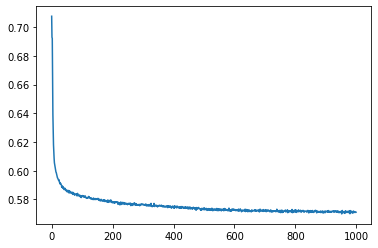

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(loss_list)
plt.savefig('loss_non.png')
plt.show()

# Model save

In [26]:
model.to('cpu')
model.eval()
torch.save(model.state_dict(), './1000epoch_16nb_2hop.pth')

embedding_array = model(whole_data.x, whole_data.edge_index).detach().numpy()
np.save('./sentece_embedding_using_graph.npy', embedding_array)

# embedding check

In [ ]:
embedding_array[sent2index["The performance of lithium–sulfur (Li–S) batteries is largely hindered by the shuttle effect caused by the dissolution of lithium polysulfides (LiPSs) and the sluggish reaction kinetics of LiPSs. Here, it is demonstrated that the nickel–cobalt double hydroxide (NiCo-DH) shells that encapsulate sulfur nanoparticles can play multiple roles in suppressing the shuttle effect and accelerating the redox kinetics of LiPSs by combining with graphene and carbon nanotubes to construct the conductive networks. The NiCo-DH shell that intimately contacts with sulfur physically confines the loss of sulfur and promotes the charge transfer and ion diffusion. More importantly, it can react with LiPSs to produce the surface-bound intermediates, which are able to anchor the soluble LiPSs and accelerate the redox kinetics. Such composite electrodes can load high contents of sulfur (>85 wt%) and the resulting Li–S battery exhibits a superior capacity (1348.1 mAh g−1 at 0.1 C), ultrahigh rate performance (697.7 mAh g−1 at 5 C), and ultralong cycle life (1500 cycles) with a decay rate of 0.015% per cycle."]]

In [28]:
with open('index2sent.pkl', 'rb') as f:
    index2sent = pickle.load(f)

with open('sent2index.pkl', 'rb') as f:
    sent2index = pickle.load(f)

def sim_sentence_reco(sentence, rec_num = 10):     # 원본 프로그램 번호, 근처 프로그램 갯수 측정
    a = embedding_array[sent2index[sentence]]
    b = np.arange(embedding_array.shape[0])
    sim_score = np.zeros_like(b)
    
    for i in b:
        vec = embedding_array[i]
        sim_score[i]= np.linalg.norm(a-vec)   # 유클리디안 norm으로 거리 측정
    max_ind = sim_score.argsort()
    max_ind = max_ind[1:rec_num+1]  # 자기 자신은 제외
    name = []
    
    for i in max_ind:
        sent= index2sent[i]
        name.append(sent)            
    original_sentence = sentence

    return name, original_sentence

In [ ]:

model1 = SentenceTransformer('/home/hoya/sentence-transformers-master/output/bert-base-uncased_finetuned')

model1.encode("The performance of lithium–sulfur (Li–S) batteries is largely hindered by the shuttle effect caused by the dissolution of lithium polysulfides (LiPSs) and the sluggish reaction kinetics of LiPSs. Here, it is demonstrated that the nickel–cobalt double hydroxide (NiCo-DH) shells that encapsulate sulfur nanoparticles can play multiple roles in suppressing the shuttle effect and accelerating the redox kinetics of LiPSs by combining with graphene and carbon nanotubes to construct the conductive networks. The NiCo-DH shell that intimately contacts with sulfur physically confines the loss of sulfur and promotes the charge transfer and ion diffusion. More importantly, it can react with LiPSs to produce the surface-bound intermediates, which are able to anchor the soluble LiPSs and accelerate the redox kinetics. Such composite electrodes can load high contents of sulfur (>85 wt%) and the resulting Li–S battery exhibits a superior capacity (1348.1 mAh g−1 at 0.1 C), ultrahigh rate performance (697.7 mAh g−1 at 5 C), and ultralong cycle life (1500 cycles) with a decay rate of 0.015% per cycle.")

In [43]:
sim_sentence_reco("cancer", 10)

(['Downstaging',
  'Streptophyta',
  'Ultracold',
  'Borylene',
  'trachea',
  'Piezo2',
  'Reporting',
  'testingPhthalic',
  'Phenyramidol',
  'angiotensinamide'],
 'cancer')

In [46]:
list(sent2index.keys())[:10]

['heptahydrate',
 "Magnetic racetrack devices are promising candidates for next-generation memories. These spintronic shift-register devices are formed from perpendicularly magnetized ferromagnet/heavy metal thin-film systems. Data are encoded in domain wall magnetic bits that have a chiral Néel structure that is stabilized by an interfacial Dzyaloshinskii–Moriya interaction. The bits are manipulated by spin currents generated from electrical currents that are passed through the heavy metal layers. Increased efficiency of the current-induced domain wall motion is a prerequisite for commercially viable racetrack devices. Here, significantly increased efficiency with substantially lower threshold current densities and enhanced domain wall velocities is demonstrated by the introduction of atomically thin 4d and 5d metal “dusting” layers at the interface between the lower magnetic layer of the racetrack (here cobalt) and platinum. The greatest efficiency is found for dusting layers of pall

In [47]:
sim_sentence_reco("The performance of lithium–sulfur (Li–S) batteries is largely hindered by the shuttle effect caused by the dissolution of lithium polysulfides (LiPSs) and the sluggish reaction kinetics of LiPSs. Here, it is demonstrated that the nickel–cobalt double hydroxide (NiCo-DH) shells that encapsulate sulfur nanoparticles can play multiple roles in suppressing the shuttle effect and accelerating the redox kinetics of LiPSs by combining with graphene and carbon nanotubes to construct the conductive networks. The NiCo-DH shell that intimately contacts with sulfur physically confines the loss of sulfur and promotes the charge transfer and ion diffusion. More importantly, it can react with LiPSs to produce the surface-bound intermediates, which are able to anchor the soluble LiPSs and accelerate the redox kinetics. Such composite electrodes can load high contents of sulfur (>85 wt%) and the resulting Li–S battery exhibits a superior capacity (1348.1 mAh g−1 at 0.1 C), ultrahigh rate performance (697.7 mAh g−1 at 5 C), and ultralong cycle life (1500 cycles) with a decay rate of 0.015% per cycle.")

(["Background: The chaperone ClpB, a bacterial protein, is a conformational antigen-mimetic of α-melanocyte-stimulating hormone (α-MSH) implicated in body weight regulation in mice. We here investigated the potential associations of gut bacterial ClpB-like gene function with obesity status and gut microbiota in humans. Results: Gut microbiota ClpB KEGG function was negatively associated with body mass index, waist circumference, and total fat mass (DEXA). The relative abundance (RA) of several phyla and families directly associated with ClpB was decreased in subjects with obesity. Specifically, the RA of Rikenellaceae, Clostridiaceae and not assigned Firmicutes were lower in subjects with obesity and positively associated with gut bacterial ClpB-like gene function (not assigned Firmicutes (r = 0.405, FDR = 2.93 × 10-2), Rikenellaceae (r = 0.217, FDR = 0.031), and Clostridiaceae (r = 0.239, FDR = 0.017)). The gut bacterial ClpB-like gene function was also linked to specific plasma metab